# Naive Bayes i Classificació


En aquest tercer lliurament es programarà un classificador, que donat un tweet el categoritzarà en una de les possibles classes. En aquesta ocasió, implementareu un classificador amb tweets de polítics.


**Què s’ha de fer?**

Volem classificar tweets corresponents a diferents polítics segons a quin partit polític pertanyen. 
A partir de tots els tweets que tenim, crearem un vector de característiques que ens descrigui cada un dels tweets. 
Finalment desenvoluparem un classificador probabilístic del tipus Naive Bayes que ens permeti identificar a quin partit polític pertany un tweet donat segons les característiques triades.


**Quina és la idea del sistema de classificació que s’ha de desenvolupar?**

El classificador és un concepte de l'aprenentatge automàtic supervisat. 
L'objectiu del classificador és donat un vector de característiques que descriuen els objectes que es volen classificar indicar a quina categoria o classe pertanyen d'entre un conjunt predeterminat. 
El procés de classificació consta de dues parts: 
(a) el procés d'aprenentatge i 
(b) el procés d'explotació o testeig. 
El procés d'aprenentatge rep exemples de parelles $(x,y)$ on $x$ són les característiques, usualment nombres reals, i $y$ és la categoria a la qual pertanyen. 
Aquest conjunt se'l coneix com a conjunt d'entrenament i ens servirà per trobar una funció $\hat{y}=h(x)$ que donada una $x$ aconsegueixi que $\hat{y}=y$. Per altra banda el procés de testeig aplica la funció $h(x)$ apresa a l'entrenament a una nova descripció per veure quina categoria li correspon.


**Classificació i llenguatge natural**

La descripció dels exemples en característiques és el punt més crític de tot sistema d'aprenentatge automàtic. 
Una de les representacions més simples per tal de descriure un text és la representació *bag-of-words*.
Aquesta representació converteix un text en un vector de $N$ paraules. 
Consisteix en seleccionar un conjunt d'$N$ paraules i per cada paraula comptar quants cops apareix en el text. 
Una versió alternativa d'aquest procés pot ser simplement indicar si apareix o no en el text.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy` i `NLTK`

*Nota: A més de les que ja es troben presents en la 1a cel·la i funcions natives de Python*

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica que serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. Durant els testos, els paràmetres (i específicament `df`) no contindran les mateixes dades que en aquest notebook, si bé si seran del mateix tipus! Per tant, no us refieu de què tinguin, per exemple, el mateix nombre de files.

## Testos automàtics

Com ja sabeu, les pràctiques es fan a través de Github Classroom. Podeu treballar-hi lliurement i es recomana que feu commits sovint, per tal que els canvis quedin reflectits de forma estructurada i modular.

Normalment treballareu a la branca `master`, però podeu fer fins a 3 cops al dia un `commit` (o `merge` de `master`) a la branca `test`. Això provocarà que es llencin un seguit de proves sobre el vostre codi, en podreu veure el resultat a la següent web: http://grade-me.education

Penseu que aquests testos són un subconjunt, petit, dels que realment farem servir per avaluar. Per tant, us recomanem que aprofiteu al màxim els 3 intents diaris, que us serviran per comprovar que els formats d'entrada i sortida siguin correctes, a més d'alguns testos bàsics de correcte funcionament.

# Preparar les dades

### **En aquesta cel·la no féu cap modificació**

Descomprimeix el zip en la carpeta "data" automàticament. La funció locate serveix per trobar la ruta relativa a la carpeta on s'està executant aquest python/ipython.

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
import zipfile
import pickle
from os.path import join, dirname

def locate(*path):
    base = globals().get('__file__', '.')
    return join(dirname(base), *path)

try:
    from IPython.core.display import HTML

    def pprint(df):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(HTML(pd.DataFrame(df).to_html()))
except:
    def pprint(df):
        print(df)

In [3]:
if __name__ == '__main__':
    print('Training data')
    df_tweets_train = pd.read_excel(locate('data', 'train.xlsx'), index_col='Id')
    pprint(df_tweets_train.head())
    print(df_tweets_train.shape)
    
    df_tweets_test = pd.read_excel(locate('data', 'test.xlsx'), index_col='Id')
    pprint(df_tweets_test.head())
    print(df_tweets_test.shape)

Training data


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
0,martarovira,erc,Últim acte de campanya! Aquí tossudament alçat...,2017-12-19 20:12:01,785,2295
1,xavierdomenechs,comuns,#Badalona necessita uns pressupostos que posin...,2018-04-27 10:04:19,55,93
2,albert_rivera,cs,Encuentro Villacís-Valls para lanzar una estra...,2018-11-17 20:34:58,357,622
3,jaumecollboni,psc,"“La palabra es como una bala, no tiene retorno...",2018-10-22 18:10:01,4,6
4,albiol_xg,ppc,"📻 Esta noche, a partir de las 22:10h, me entre...",2018-08-16 10:30:27,20,47


(1920, 6)


,text,retweet_count,favorite_count
Id,,,
0,Avui hem représ la Comissió Mixta amb el @gove...,67,103
1,"Torra anunció un ""otoño caliente"" para aumenta...",856,1501
2,Demà cal sortir als carrers per dir que #Barce...,144,174
3,“Cercàvem or i vam baixar a la mina.\nI la fos...,338,1560
4,"Molt senzill d'entendre, companya: \n1.- L'ALL...",4932,7253


(480, 3)


# Implementació

Dividirem el notebook en 3 seccions que es complementen una a l'altra:

1. Anàlisis de dades: Informació bàsica sobre els tweets
2. Processament de les dades: Creació d'un vector de característiques a partir dels tweets
3. Classificació amb Naive Bayes

### Anàlisis de dades

El primer que haurem de fer és analitzar les dades mitjançant diferents funcions.

In [4]:
def count_tweets(df):
    """
    Retorna el número de tweets en el dataframe
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : número de tweets
    """
    
    return df.shape[0]

def get_politicians(df):
    """
    Retorna els usuaris dels polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb el nom dels usuaris
    """
    
    return df['username'].unique()

def count_politicians(df):
    """
    Retorna la quantitat de polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    
    return len(get_politicians(df))

def get_political_party(df):
    """
    Retorna els partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb el nom dels partits polítics que han tuitejat
    """  
    
    return df['party'].unique()

def count_political_party(df):
    """
    Retorna la quantitat de partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quantitat d'usuaris que han tuitejat
    """
    return len(get_political_party(df))

def count_tweet_politician(df):
    """
    Retorna la quantitat de tweets per polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Serie amb la quanitat de tweets per polític
    """
    return df.groupby(['username']).size()

def count_tweet_party(df):
    """
    Retorna la quantitat de tweets per partit polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Serie amb la quantitat de tweets per partit polític
    """
    
    return df.groupby(['party']).size()

def top_retweet(df, n):
    """
    Retorna els n tweets que han sigut més retuitejats
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Serie amb els top retuits
    """
    
    return df.sort_values(by=['retweet_count'],ascending=False)[:n]
    
def top_favorite(df, n):
    """
    Retorna els n tweets més favorits
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Serie amb els top favorits
    """
    return df.sort_values(by=['favorite_count'],ascending=False)[:n]

<div class="alert alert-info">
Correcte
</div>

<div class="alert alert-warning">
1/1
</div>

1920
['martarovira' 'xavierdomenechs' 'albert_rivera' 'jaumecollboni'
 'albiol_xg' 'miqueliceta' 'quimtorraipla' 'adacolau' 'santirodriguez'
 'krls' 'joantarda' 'inesarrimadas'] 12
['erc' 'comuns' 'cs' 'psc' 'ppc' 'jxcat'] 6


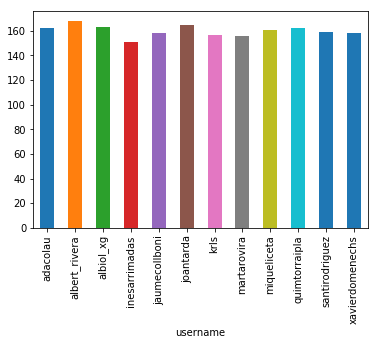

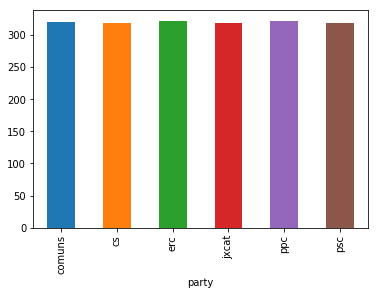

,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,Que una republicana defienda la República es b...,2018-10-26 22:17:38,11706,26838
781,martarovira,erc,A tots els demòcrates: no pararem fins que tor...,2017-11-02 17:42:06,10403,19991
138,krls,jxcat,Una causa que necessiti ser defensada amb cúte...,2018-08-29 20:21:30,10086,20357
1664,martarovira,erc,.@junqueras President d'un partit amb 86 anys ...,2017-12-13 21:17:18,9445,15947
1515,krls,jxcat,"Perdoneu, però això és tan greu que si no hi h...",2018-09-19 20:16:22,8806,12509


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,Que una republicana defienda la República es b...,2018-10-26 22:17:38,11706,26838
138,krls,jxcat,Una causa que necessiti ser defensada amb cúte...,2018-08-29 20:21:30,10086,20357
174,krls,jxcat,Acabo d'arribar a #Escòcia convidat pel Fòrum ...,2018-08-24 17:55:01,6783,20018
781,martarovira,erc,A tots els demòcrates: no pararem fins que tor...,2017-11-02 17:42:06,10403,19991
1043,krls,jxcat,Una gran #Diada2018 per avançar cap a la repúb...,2018-09-11 18:48:43,6372,18950


In [5]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    print(count_tweets(df_tweets_train))
    print(get_politicians(df_tweets_train), count_politicians(df_tweets_train))
    print(get_political_party(df_tweets_train), count_political_party(df_tweets_train))
    
    count_tweet_politician(df_tweets_train).plot.bar()
    plt.show()
    
    count_tweet_party(df_tweets_train).plot.bar()
    plt.show()
    
    pprint(top_retweet(df_tweets_train, 5))
    pprint(top_favorite(df_tweets_train, 5))

### Comptar paraules

El primer que haurem d'implementar és la funció *normalize* que normalitzarà les paraules.


No modificar la següent cel·la, s'encarrega d'evitar càlculs repetits.

In [6]:
def memo(f):
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
    return memodict(f)

In [7]:
@memo    
def normalize(word):
    """
    Funció que donada una paraula la normalitzi
    Exemple: Taller DELS noUS USOS ---> tallers dels nous usos
    
    :param word: paraula a normalitzar
    :return : paraula normalitzada
    """
    
    # Eliminar els accents
    accents = {'à':'a','á':'a','è':'e','é':'e','í':'i','ò':'o','ó':'o','ú':'u'}
    for k,v in accents.items():
        word = word.replace(k,v)
    
    # Eliminar els pronoms del català
    toRemove = ["l'","d'","t'","n'","s'","m'","'m","'t","'s","'l","'ls","'n","'ns"]
    
    for c in toRemove:
        word = word.replace(c,'')
    
    # Utilitzar regular expressions i passar a minus
    return re.sub(r'[^\w\s\'\@\#\-]','', word.lower())

<div class="alert alert-info">
Correcte
</div>

<div class="alert alert-warning">
1/1
</div>

In [8]:
def count_words(df):
    """
    Funció que ha de construir un diccionari que contingui totes les paraules que s'han trobat indicant
    el total de cops que ha aparegut i el nombre de tweets on apareix
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : Diccionari amb el format {word : {n_ocur: valor, n_tweets: valor}, ...}
    """
    
    dic = dict()
    tweets = df['text']
    # Per cada tweet
    for tweet in tweets:
        seen_words = set()
        # Per cada paraula del tweet
        for word in tweet.split():
            norm_word = normalize(word) # normalitzar
            current = dic.get(norm_word)
            if not current:
                # Si no està al diccionari inicialitzem
                dicc_node = {'n_ocur':1, 'n_tweets':1}
                dic[norm_word] = dicc_node
            else: 
                # Actualitzar el diccionari
                dic[norm_word]['n_ocur'] = dic[norm_word]['n_ocur'] + 1
                if norm_word not in seen_words:
                    # Si no hem vist aquesta paraula ja en el mateix tweet incrementem n_tweets
                    dic[norm_word]['n_tweets'] = dic[norm_word]['n_tweets'] + 1
                
            seen_words.add(norm_word)
            
    return dic
            

<div class="alert alert-info">
Correcte
</div>

<div class="alert alert-warning">
3/3
</div>

In [9]:
if __name__ == '__main__':
    dicc_text = count_words(df_tweets_train)
    print(len(dicc_text))

11574


El resultat serà un diccionari tipus (no necessàriament amb aquest valors):

```python
{
    'badalona' : {'n_ocur': 88, 'n_tweets': 76},
    'que': {'n_ocur': 123, 'n_tweets': 65},
    ...
}
```

### Contar paraules per partit polític

In [10]:
def count_words_parties(df):
    """
    Funció que ha de construir un diccionari que conté la freqüència de les 
    paraules i el número de tweets on ha aparegut. 
    Aquesta informació ha de ser dividida pels diferents partits polítics. 
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : Diccionari amb el format {Partit_Politic : {word : {n_ocur: valor, n_news: valor} } }
    """
    
    # Per cada partit hagafem un df on només tinguem els tweets del partit en qüestió
    # i cridem a la funció anterior
    return {p : count_words(df.loc[(df['party'] == p)]) for p in get_political_party(df)}

In [11]:
if __name__ == '__main__':
    words_parties = count_words_parties(df_tweets_train)
    print(len(words_parties))
    #print(len(words_parties['psc']))

6


El resultat serà un diccionari tipus (no necessàriament amb aquests valors):

```python
{
    'comuns': {
        'badalona' : {'n_ocur': 88, 'n_tweets': 76},
        'que': {'n_ocur': 123, 'n_tweets': 65}
        ...
    },
    ...
    'psc': {
        'badalona' : {'n_ocur': 18, 'n_tweets': 17},
        'que': {'n_ocur': 154, 'n_tweets': 66}
    }
    ...
}
```

### Paraules més freqüents als tweets


**El problema de com escollir el vector de característiques**

L'elecció de les paraules que formen el vector de característiques és un pas crític. 
En funció de com de bona sigui aquesta descripció, millor funcionarà el sistema. 
Tot i que us deixem a vosaltres la política de creació del vector de característiques us donem una d'exemple. 
Per saber quines paraules fer servir una possible estratègia és agafar aquelles paraules que apareixen entre un 10 i un 50 per cent del total (sense tenir en compte el partit). 
Podeu experimentar variant aquests valors.

In [12]:
def topNwords(df, words, N, skip=None):
    """
    Funció que crea un diccionari amb les N paraules més representatives 
    (les que apareixen amb més freqüència) de cadascun dels partits polítics.
    
    Tingueu en compte que també haureu de filtrar aquelles paraules que apareixen en la majoria 
    de tweets, així com les que únicament apareixen en un conjunt molt petit de tweets
    
    :param df: DataFrame amb els tweets i la informació associada
    :param words: diccionari amb les paraules i la seva freqüència
    :param N: nombre de paraules més representatives que volem considerar
    :param skip: paràmetre lliure per considerar polítiques i estratègies per ignorar paraules
    :return : Diccionari amb el format {Partit_Polític_1: llista_top_words_party_1,  
                                        Partit_Polític_2: llista_top_words_party_2, ...} 
    """

    dic = dict()
    n_partits = len(words)
    
    # Per cada partit,paraules de words_parties
    for k,v in words.items():
        # Ordenem segons el numero de ocurrencies de les paraules de cada partit
        a = sorted(v, key=lambda x: v[x]['n_ocur'], reverse=True)
        
        if skip: # Si volvem filter per una llista
            final = [x for x in a if x not in skip][:N]
            dic[k] = final
        else:
            # Si no volem filtrar per llista hagafem només aquelles amb un percentatge
            # dividint pel nombre de partits
            final = [x for x in a if float(words[k][x]['n_ocur']/n_partits)<0.67][:N]
            dic[k] = final

    return dic
       


<div class="alert alert-info">
Bé per filtrar
</div>

<div class="alert alert-warning">
2/2
</div>

In [13]:
if __name__ == '__main__':
    
    filter_list = ["la","de","i","a","que","què","és","el","la","les","las","d'",
                   "l'","n'","un","una","uns","unes","pel","pels","ha","han","ens","en","per","ho","y","tu",
                  "o","x","té","ja","va","vam","has","los","he","tan","hi","es","dels","no","q","els",
                  "del","amb","d","al","lo","","més","com","fer","hem","als","qui","on","para","con",
                  "por","sobre","només","us","això","se","más","su","aquest","aquests","aquesta","to","esta",
                  "mi","van","tot","me","nos","molt","este","como"]
    
    top_words = topNwords(df_tweets_train, words_parties, 20)
    
    for k,v in top_words.items():
        print(k,v, "\n")
    #print(top_words)
    

erc ['acte', 'sentit', 'aixi', 'lautodeterminacio', 'injusticia', 'paraules', 'pregunta', 'europees', 'dos', 'agressions', '@jordiborras', 'ets', 'garanties', 'encara', 'congreso', 'podem', 'preses', 'senat', 'democrates', 'families'] 

comuns ['necessita', 'pressupostos', 'socials', 'retallades', 'estas', 'nuestro', 'derecho', 'pogut', 'parlar', 'sha', 'aquestes', 'sera', 'with', 'necesitamos', 'mi', 'dun', 'bon', 'interior', 'aixi', 'som'] 

cs ['magnifica', 'hacen', 'explica', 'politico', 'sanchez-iglesias', 'socialista', 'merecen', '@cs_andalucia', 'adversarios', 'aun', 'indulto', 'siga', 'avui', 'durante', 'valientes', 'libres', 'deja', 'pedimos', 'otegi', 'lugar'] 

psc ['derecha', 'todas', 'reforma', 'justicia', 'viure', 'desigualdad', 'construir', 'estat', 'judicial', 'encara', 'parlar', 'restauradors', 'veïnes', 'veïns', 'projecte', 'tothom', 'todo', 'sant', 'estamos', '@ballarinmontsek'] 

ppc ['proces', 'violencia', 'nueva', 'centro', 'haya', 'muchos', 'disfrutando', 'social

El resultat serà un diccionari tipus (no necessàriament amb aquests valors):

```python
{
    'comuns': ['badalona', 'que',...],
    ...
    'psc': ['partit', 'barcelona',...]
    ...
}
```

### Vector de Característiques
Creeu el vector de característiques necessari per a fer l’entrenament del Naïve Bayes

In [14]:
def create_features(df, top_words): 
    """
    Funció que crea un vector de característiques necessari per a l'entrenament del classificador Naive Bayes
    
    :params df: DataFrame amb els tweets i la informació associada
    :params top_words: ha de ser el diccionari que retorna topNWords
    :return : diccionari o pd.Series que conté un np.array per a 
        cadascuna dels tweets amb el vector de característiques corresponent.
    """
    
    tw = []
    # Per cada partit, paraules_més_freqüents_del_partit
    for k,v in top_words.items():
        tw += v
    tw = set(tw) # Fem un Set - no repetits - ajuntant totes les paraules freqüents de tots els partits
    
    n_words = len(tw)
    
    dic = dict()
    tweets = df['text']
    indices = df.index.tolist()
    
    # Per cada tweet
    for i,tweet in enumerate(tweets):
        # Creem un vector de característiques amb tot 0's 
        # del tamany de les nostres paraules freqüents
        tweet_vector = np.zeros(n_words, dtype=int)
        # Fiquem en una llista les paraules normalitzades de cada tweet
        norm_tweet = [normalize(word) for word in tweet.split()]
        
        tweet_tw = []
        # Per cada paraula_freqüent
        for pos,w in enumerate(tw):
            # Comprovem si la paraula freqüent hi és al tweet
            if w in norm_tweet:
                # Si hi és actualitzem el vector de característiques a la posició X amb un 1
                tweet_vector[pos] = 1
        
        dic[indices[i]] = tweet_vector
        
    return dic

        

<div class="alert alert-info">
Correcte
</div>

<div class="alert alert-warning">
1/1
</div>

In [15]:
if __name__ == '__main__':
    N = 20 # Aquest paràmetre el podem canviar i fer proves per avaluar quin és el millor valor. 
    words_parties = count_words_parties(df_tweets_train)
    top_words = topNwords(df_tweets_train, words_parties, N)
    dict_feat_vector = create_features(df_tweets_train, top_words)

El resultat serà un diccionari tipus (no necessàriament amb aquests valors):

```python
{
    0: np.array([0, 1, 1, 0, ...]),
    1: np.array([0, 1, 1, 1, ...]),
    ...
}
```

### El classificador Naïve Bayes

Un cop tenim una representació necessitem un procés d'aprenentatge que ens permeti passar de la descripció a una categoria. 
En aquest lliurament farem servir el classificador Naïve Bayes. 
Aquest classificador forma part de la família de classificadors probabilístics. 
La sortida d'un classificador probabilístic és un valor de probabilitat donat un exemple per cadascuna de les categories. 
La decisió final correspon a la categoria amb més probabilitat. 


Els classificadors probabilístics Bayesians es basen en el teorema de Bayes per realitzar els càlculs per trobar la probabilitat condicionada: 
$$ p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$
d'on podem extreure que: 
$$ p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$


En molts casos $p(y)$ i $p(x)$ són desconeguts i es consideren equiprobables. 
Per tant, la decisió se simplifica a:
$$ p(y|x) = c · p(x|y)$$


Les deduccions fins a aquest punt són vàlides per la majoria de classificadors Bayesians. 
Naïve Bayes es distingeix de la resta perquè imposa una condició encara més restrictiva. 
Considerem $x=(x_1, \cdots, x_n)$ un conjunt d'$N$ variables aleatòries. 
Naïve Bayes assumeix que totes elles són independents entre elles i per tant podem escriure:
$$p(x_1,x_2,...,x_N | y) = p(x_1|y)p(x_2|y)...p(x_N|y)$$


Podem interpretar l'anterior equació de la següent forma: La probabilitat què el tweet descrit pel vector de característiques (0,1,0,1,1,1) sigui de la classe "comuns" és proporcional al producte de la probabilitat que la primera paraula del vector no aparegui en els tweets sobre "comuns"  per la probabilitat que la segona paraula sí que hi aparegui, etc.


**Estimant les probabilitats marginals condicionades**

L'últim pas que ens queda és trobar el valor de les probabilitats condicionades. 
Farem servir la representació de $0$'s i $1$'s indicant que la paraula no apareix (0) o sí apareix (1) al tweet. 
Per trobar el valor de la probabilitat condicionada farem servir una aproximació freqüentista a la probabilitat. 
Això vol dir que calcularem la freqüència d'aparició de cada paraula per a cada categoria. 
Aquest càlcul es fa dividint el nombre de tweets de la categoria que apareix la paraula pel nombre total de tweets d'aquella categoria. 

En general:
$$p(x = \text{"badalona"} | y = C)= \frac{A}{B} $$
on A és el número de tweets de la categoria C on hi apareix la paraula 'badalona' i B és el número total de tweets de la categoria C.


### Punts dèbils:

**El problema de la probabilitat 0**

Si us hi fixeu bé, la probabilitat pot ser 0 !! 
Això vol dir, que si en el tweet no hi apareix una paraula, no pot ser classificada com un partit polític.
No sembla raonable que s'assigni o no en aquesta categoria segons si en el tweet hi apareix o no una única paraula. 
Per tant, el que s'acostuma a fer és donar una baixa probabilitat en comptes de zero. 
Una de les possibles solucions és fer servir la correcció de Laplace. 
Seguint l'exemple anterior la correcció de Laplace és
$$p(x= \text{"badalona"} | y = 'C' ) = \frac{A+1}{B+M}$$ 
on M és el nombre de categories.

**El problema del "underflow"**

La funció que hem de calcular en el Naive Bayes és un producte. 
El nombre de característiques del vector és el nombre de termes del producte. 
Aquests nombres són iguals o menors a 1, si els multipliquem tots entre ells, el resultat serà massa petit per a representar-lo en un nombre de punt flotant i el càlcul acabarà sent reduït a zero. 
Per solucionar aquest problema en comptes d'operar fent multiplicacions, se sol passar a l'escala logarítmica i allà operar fent servir sumes en comptes de multiplicacions.

### Classificar:

Donat un vector de característiques $x=(x_1,...,x_n)$, per classificar el que farem serà calcular la probabilitat de pertànyer a cada un dels partits polítics:

$$p(\text{comuns}|x) = p(\text{comuns})\prod_{i=1}^np(x_i|\text{comuns})$$
$$\cdots$$
$$p(\text{psc}|x) = p(\text{psc})\prod_{i=1}^np(x_i|\text{psc})$$

I finalment, el tweet és del partit de probabilitat màxima. Tingues en compte que per $x_i = 0$ s'ha de considerar la probabilitat inversa, és a dir, la probabilitat de ser de la clase $C$ quan $x_i = 0$ ve donada per $1 - p(x_i|C)$

Implementeu la funció d'aprenentatge del classificador Naïve Bayes (funció **naive_bayes_learn()**). La funció ha de mostrar per pantalla el resultat obtingut.
L'**error d'entrenament** es troba calculant el percentatge d'errors que s'obtenen quan es fa el testeig amb les mateixes dades utilitzades per fer entrenament (aprenentatge). 
Aquest error és un valor molt optimista de com funcionarà el classificador i mai s'ha de prendre com a mesura per comparar classificadors. 

In [16]:
def naive_bayes_learn(df, feats):
    """
    Funció que estima les probabilitats marginals condicionades, és a dir per cada
    partit polític C estima $p(x_i|C) = (A + 1) / (B + M)$
    
    :params df: DataFrame amb els tweets i la informació associada
    :params feats: vector de característiques de cada tweet
    :return : probabilitats marginals condicionades
    """
    dic = dict()
    partits = get_political_party(df)
    n_partits = len(partits) # Quantitat de partits = (M)
    
    # Per cada partit
    for p in partits:
        # agafar el dataframe només amb els tweets del partit en concret
        df_p = df.loc[(df['party'] == p)]
        # Hagafar els indexes corresponents
        p_idx = df_p.index.tolist()
        
        n_tweets_p = len(p_idx)# Longitud de tweets del partit = (B) 
        
        # Creem un vector del tamany del vector de característiques
        p_word_times = np.zeros(len(feats[0]), dtype=float)
        
        # Per cada index del partit
        for idx in p_idx:
            # Sumem vectors de característiques per treure el numero de tweets on la paraula
            # 'X' apareix en cada partit = (A)
            p_word_times = np.add(p_word_times, feats[idx])
        
        # Per cada valor A apliquem la fórmula
        for pos,word_times in enumerate(p_word_times):
            p_word_times[pos] = (word_times+1)/(n_tweets_p+n_partits)
            
        dic[p] = p_word_times
        
    # El diccionari que retornem te l'estructura:
    # Partit: [P0, P1, P2, P3, ..., PN]
    # De manera que tenim la probabilitat de cada paraula del vector de característiques
    # per cada partit
    return dic
        
    

<div class="alert alert-info">
Bé, tot i que aquesta línia `p_word_times = np.add(p_word_times, feats[idx])` és un pel rara, podríeu fer `p_word_times += feats[idx]` i seria el mateix
</div>

<div class="alert alert-warning">
2/2
</div>

In [17]:
def split_train_test(df, split):
    """
    Funció que separa les dades en aprenentatge i testeig
    
    :param df:
    :param split: proporció de les dades que seran per l'entrenament
    :return : retorna dos dataframes corresponents a l'entrenament i al test
    """
    assert split <= 1, 'Split must be between 0 and 1'
    
    length = count_tweets(df)
    
    to_learn = round(split * length)
    
    # Dividir segons el tamany per agafar només les files corresponents
    df_to_learn = df.loc[:to_learn, :]
    df_to_test = df.loc[to_learn+1:, :]
    
    return (df_to_learn, df_to_test)
    

In [18]:
import sys

def naive_bayes(df_train, feat_train, feat_test, df_test=None):
    """
    Funció que implementa el classificador Naive_Bayes, és a dir entrena amb les
    característiques d'entrenament i després utilitza les probabilitats estimades
    per classificar els vectors de test, segons la fórmula
    p(C_j|x) = p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)
    i agafant la màxima.
    
    Tingues en compte el problema de l'underflow:
    log(p(C_j|x)) = log(p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)) =
                  = log(P(C_j)) + log(p(x_1|C_j)) + ... + log(p(x_n|C_j))
                  
    I recorda, per x_i = 0 cal considerar 1 - p(x_1|C_j).
    
    Si df_test no és None, ha de calcular l'encert sobre les dades de test. És a dir,
    després de classificar feat_test ha de comparar la classificació amb la classe
    real i dir (print) quin percentatge d'encert ha obtingut.
    
    :param df_train: DataFrame amb els tweets que s'utilitzaran per a l'entrenament
    :param feat_train: Diccionari amb els vectors de característiques de cada tweet de l'entrenament
    :param feat_test: Diccionari amb els vectors de característiques de cada tweet de test
    :param df_test: En cas d'estar disponible (per Kaggle no hi és), 
        DataFrame amb els tweets que s'utilitzaran per a test
    
    :return : Una sèrie on l'índex correspon amb els índexs de df_test i els valors són la
        classificació retornada per Naive Bayes
    """
    probs_trained = naive_bayes_learn(df_train, feat_train) # Entrenament
    partits = get_political_party(df_train) # agafem els partits
    
    tweets = []
    # Per cada vector de característiques del test
    for key,value in feat_test.items():
        tweet_probs = [] # (p:prob)
        for p in partits:
            # Per cada partit agafem el vector de probabilitats del partit
            probs_partits = probs_trained[p] 
            current_prob = 0
            # Per cada paraula del vector de característiques del test
            for pos,w_times in enumerate(value):
                # Agafem la probabilitat de l'entrenament de la paraula per al partit X
                p_word_train_prob = probs_partits[pos]
                if w_times == 0: # Si la paraula en el tweet no surt fem 1 - prob
                    p_word_train_prob = 1 - p_word_train_prob
                # Fem la suma de logaritmes segons la formula
                current_prob += np.log(p_word_train_prob)
            # guardem una tupla (partit, probabilitat_de_ser) 
            tweet_probs.append((p,current_prob))
        # Ordenem les probabilitats del tweet del test per agafar la máxima
        tweet_probs = sorted(tweet_probs, key=lambda x: x[1], reverse=True)
        # Guardem el partit que considerem que ha escrit aquest tweet
        tweets.append(tweet_probs[0][0])

    # Si tenem df_test fem les comprovacions per saber els encerts 
    # fent la comparació amb les nostres suposicions
    if not df_test is None:
        encerts = 0
        c = df_test['party']
        for a,v in enumerate(c):
            if tweets[a] == v:
                encerts += 1
        print("Encerts: ", encerts, " of ", len(tweets), "::", (encerts/len(tweets))*100, "% correct")
        
    result = pd.Series(data=tweets, index=feat_test.keys())
    return result
    
        
      

<div class="alert alert-info">
Molt bé!
</div>

<div class="alert alert-warning">
4/4
</div>

In [20]:
if __name__ == '__main__':
    df_train, df_test = split_train_test(df_tweets_train, 0.8)

    N = 50 # Aquest paràmetre el podem canviar i fer proves per avaluar quin és el millor valor. 
    words_topics = count_words_parties(df_train)
    top_words = topNwords(df_train, words_topics, N)
    
    feat_train = create_features(df_train, top_words)
    feat_test = create_features(df_test, top_words)
        
    result = naive_bayes(df_train, feat_train, feat_test, df_test)
    
    pprint(result.head())

Encerts:  168  of  383 :: 43.86422976501306 % correct


,0
1537,jxcat
1538,psc
1539,jxcat
1540,erc
1541,erc


<div class="alert alert-success">
15/15
</div>

# Kaggle

https://www.kaggle.com/t/98e3f4a3150947ebbc634c661bb79560

In [20]:
if __name__ == '__main__': 
    words_topics = count_words_parties(df_tweets_train)
    top_words = topNwords(df_tweets_train, words_topics, N)
    
    feat_train = create_features(df_tweets_train, top_words)
    feat_test = create_features(df_tweets_test, top_words)
    
    result = naive_bayes(df_tweets_train, feat_train, feat_test)
    result.index.name = 'tweet_id'
    result.name = 'party'
    result.to_frame().to_csv('submission.csv')
    pprint(result.head())

,party
tweet_id,
0,erc
1,cs
2,comuns
3,psc
4,psc


# Apèndix
## Com construir un classificador a partir d'un model de probabiltiats


El problema amb la formulació és que si el nombre de característiques $n$ és gran, llavors el càlcul de les probabilitats no és factible. 
Per aquest motiu cal reformar el model utilitzant el teorema de Bayes, la probabilitat condicional pot ser descomposta per
$$p(C_k|X) = \frac{p(C_k) \cdot p(X|C_k)}{p(X)}
$$

En el nostre cas, el denominador de la fracció no depèn de $C$, i com els valors del vector de característiques $x_{i}$ està donat, aquest és constant. 
El numerador és equivalent al model de la probabilitat de la junta $p(C_k, x_1, \cdots, x_n)$ que mitjançant la regla de la cadena pot ser reescrit de la manera següent:

\begin{aligned}p(C_{k},x_{1},\dots ,x_{n})&=p(x_{1},\dots ,x_{n},C_{k})\\&=p(x_{1}\mid x_{2},\dots ,x_{n},C_{k})p(x_{2},\dots ,x_{n},C_{k})\\&=p(x_{1}\mid x_{2},\dots ,x_{n},C_{k})p(x_{2}\mid x_{3},\dots ,x_{n},C_{k})p(x_{3},\dots ,x_{n},C_{k})\\&=\dots \\&=p(x_{1}\mid x_{2},\dots ,x_{n},C_{k})p(x_{2}\mid x_{3},\dots ,x_{n},C_{k})\dots p(x_{n-1}\mid x_{n},C_{k})p(x_{n}\mid -C_{k})p(C_{k})\\\end{aligned}

Si recordem que les variables $x_i$ són independents, obtenim que

$$p(x_{i}|x_{i+1},\dots ,x_{n},C_{k}) = p(x_{i}| C_{k})$$

Per tant, el model pot ser expressat:

\begin{aligned}p(C_{k}\mid x_{1},\dots ,x_{n})&\varpropto p(C_{k},x_{1},\dots ,x_{n})\\&=p(C_{k})\ p(x_{1}\mid C_{k})\ p(x_{2}\mid C_{k})\ p(x_{3}\mid C_{k})\ \cdots \\&=p(C_{k})\prod _{i=1}^{n}p(x_{i}\mid C_{k})\,,\end{aligned}

on $\varpropto$ denota proporcionalitat.

El classificador Naive Bayes combina aquest model amb una regla de decisió. 
Una regla comuna és triar la hipòtesi que és més probable, això es coneix com la regla de decisió a posteriori màxima o MAP. 
El classificador corresponent, un classificador de Bayes, és la funció que assigna una etiqueta de classe $\hat{y} = C_{k}$ per alguns $k$ de la següent manera:

$$\hat{y}={\underset {k\in \{1,\dots ,K\}}{\operatorname {argmax} }}\ p(C_{k})\displaystyle \prod _{i=1}^{n}p(x_{i}\mid C_{k}).$$